## CartPole Skating

> **Problem**: If Peter wants to escape from the wolf, he needs to be able to move faster than him. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

First, let's install the gym and import required libraries:

In [1]:
import os
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

## Create a cartpole environment

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
0


To see how the environment works, let's run a short simulation for 100 steps.

In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

a:\EDUCATION\ML-Starter\venv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
a:\EDUCATION\ML-Starter\venv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


During simulation, we need to get observations in order to decide how to act. In fact, `step` function returns us back current observations, reward function, and the `done` flag that indicates whether it makes sense to continue the simulation or not:

In [4]:
env.reset()

done = False
while not done:
    env.render()
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    print(f"{obs} -> {rew}")
env.close()

[-0.04495028 -0.17412168  0.0197036   0.2847484 ] -> 1.0
[-0.04843271  0.0207138   0.02539857 -0.0016556 ] -> 1.0
[-0.04801843 -0.17476302  0.02536545  0.29893145] -> 1.0
[-0.05151369  0.01998835  0.03134408  0.01435499] -> 1.0
[-0.05111393 -0.17556876  0.03163118  0.31676024] -> 1.0
[-0.0546253  -0.37112665  0.03796639  0.61924833] -> 1.0
[-0.06204784 -0.17655498  0.05035135  0.33876058] -> 1.0
[-0.06557894  0.01781569  0.05712657  0.06237114] -> 1.0
[-0.06522262 -0.17807682  0.05837399  0.37251663] -> 1.0
[-0.06878415 -0.37397733  0.06582432  0.68301916] -> 1.0
[-0.0762637 -0.5699486  0.0794847  0.9956778] -> 1.0
[-0.08766267 -0.37597448  0.09939826  0.7289792 ] -> 1.0
[-0.09518217 -0.18235673  0.11397784  0.46916106] -> 1.0
[-0.0988293   0.01098616  0.12336107  0.21446544] -> 1.0
[-0.09860957 -0.18566369  0.12765038  0.54337484] -> 1.0
[-0.10232285  0.00745506  0.13851787  0.293481  ] -> 1.0
[-0.10217375 -0.18934199  0.14438748  0.62644327] -> 1.0
[-0.10596059 -0.38615277  0.1569163

We can get min and max value of those numbers:

In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8               -inf -0.41887903        -inf]
[4.8               inf 0.41887903        inf]


## State Discretization

In [6]:
def flatten_obs(obs):
    if isinstance(obs, dict):
        return np.concatenate([flatten_obs(v) for v in obs.values()])
    elif isinstance(obs, (tuple, list)):
        return np.concatenate([flatten_obs(v) for v in obs if not isinstance(v, dict)])
    else:
        return np.array(obs).flatten()

def discretize(x, bin_width=0.1):
    x = flatten_obs(x)
    denom = np.full_like(x, fill_value=bin_width, dtype=float)
    result = (x / denom).astype(int)
    if result.shape == ():  # scalar
        return (int(result),)
    return tuple(result)

Let's also explore other discretization method using bins:

In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values.

In [8]:
env.reset()

done = False
while not done:
    # env.render()
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    # print(discretize_bins(obs))
    print(discretize(obs))

(np.int64(0), np.int64(-1), np.int64(0), np.int64(3))
(np.int64(0), np.int64(-3), np.int64(0), np.int64(6))
(np.int64(0), np.int64(-1), np.int64(0), np.int64(3))
(np.int64(0), np.int64(-3), np.int64(0), np.int64(6))
(np.int64(0), np.int64(-1), np.int64(0), np.int64(3))
(np.int64(0), np.int64(-3), np.int64(0), np.int64(6))
(np.int64(0), np.int64(-1), np.int64(0), np.int64(3))
(np.int64(0), np.int64(0), np.int64(0), np.int64(1))
(np.int64(0), np.int64(-1), np.int64(0), np.int64(4))
(np.int64(0), np.int64(0), np.int64(0), np.int64(1))
(np.int64(0), np.int64(-1), np.int64(1), np.int64(5))
(np.int64(0), np.int64(-3), np.int64(1), np.int64(8))
(np.int64(0), np.int64(-5), np.int64(1), np.int64(11))
(np.int64(0), np.int64(-7), np.int64(1), np.int64(14))
(np.int64(0), np.int64(-5), np.int64(1), np.int64(12))
(np.int64(0), np.int64(-7), np.int64(2), np.int64(15))
(np.int64(0), np.int64(-9), np.int64(2), np.int64(19))


## Q-Table Structure

In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

## Let's Start Q-Learning!

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs[0])
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 13.0, alpha=0.3, epsilon=0.9


5000: 12.7172, alpha=0.3, epsilon=0.9
10000: 12.66, alpha=0.3, epsilon=0.9
15000: 12.7564, alpha=0.3, epsilon=0.9
20000: 12.7496, alpha=0.3, epsilon=0.9
25000: 12.7542, alpha=0.3, epsilon=0.9
30000: 12.7076, alpha=0.3, epsilon=0.9
35000: 12.595, alpha=0.3, epsilon=0.9
40000: 12.6124, alpha=0.3, epsilon=0.9
45000: 12.6952, alpha=0.3, epsilon=0.9
50000: 12.704, alpha=0.3, epsilon=0.9
55000: 12.544, alpha=0.3, epsilon=0.9
60000: 12.5894, alpha=0.3, epsilon=0.9
65000: 12.7118, alpha=0.3, epsilon=0.9
70000: 12.6184, alpha=0.3, epsilon=0.9
75000: 12.6034, alpha=0.3, epsilon=0.9
80000: 12.6138, alpha=0.3, epsilon=0.9
85000: 12.6366, alpha=0.3, epsilon=0.9
90000: 12.7476, alpha=0.3, epsilon=0.9
95000: 12.6052, alpha=0.3, epsilon=0.9


## Plotting Training Progress

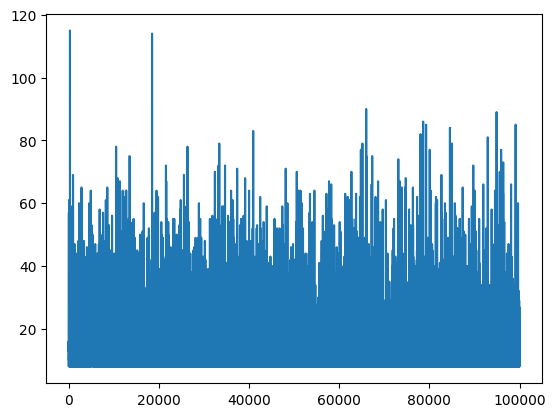

In [12]:
plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate **running average** over series of experiments, let's say 100. This can be done conveniently using `np.convolve`:

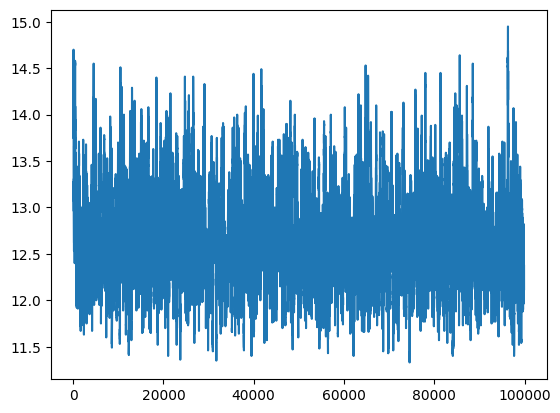

In [13]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

## Varying Hyperparameters and Seeing the Result in Action

Now it would be interesting to actually see how the trained model behaves. Let's run the simulation, and we will be following the same action selection strategy as during training: sampling according to the probability distribution in Q-Table: 

In [14]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs, _, terminated, truncated, _ = env.step(a)
   done = terminated or truncated
env.close()


## Saving result to an animated GIF

If you want to impress your friends, you may want to send them the animated GIF picture of the balancing pole. To do this, we can invoke `env.render` to produce an image frame, and then save those to animated GIF using PIL library:

In [15]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, _ = env.reset()
done = False
i=0
ims = []

notebook_dir = os.getcwd()
images_dir = os.path.abspath(os.path.join(notebook_dir, '..', 'images'))
os.makedirs(images_dir, exist_ok=True)

while not done:
   s = discretize(obs)
   img = env.render()
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs, _, terminated, truncated, _ = env.step(a)
   done = terminated or truncated
   i+=1
env.close()
gif_path = os.path.join(images_dir, 'cartpole-balance.gif')
ims[0].save(gif_path, save_all=True, append_images=ims[1::2], loop=0, duration=5)
print("Saved GIF to:", gif_path)
print(i)

Saved GIF to: a:\EDUCATION\ML-Starter\8-Reinforcement\2-Gym\images\cartpole-balance.gif
30
